## Data Transformations and agumentations

Topics  
- Introduction to Data Transformation
- Apply transformations to segmentation data - Resize, crop, flip, padding and scale
- Applying color transformations - Channel shift, grayscale, Contrast adjustments, Brightness adjustments, Saturations adjustments
- Unifying all the transformations
- Buidling keras data loader for image_segmentation

### 1. Introduction to Data Transformation
Data transformations are a way of agumenting the dataset and generalizing the network to various disturbances and thus improving the network performace. 

Since our coco dataset only contains ~0.1 million images for training where the number of parameters(see later) exceeds >1 million,  Data agumentation using transformations plays an important role. 

Some of the **image transformations** includes.  
1) Flip  
2) Crop  
3) scale  
4) Resize  
5) color transforms  

we cannot directly use our **keras Image processing** ([Link](https://keras.io/preprocessing/image/)) for segmentation task because the module is written for only image classification task. In image segmentation, if we resize the input image, we also need to resize the output image to the same size. Right now ImageDataGenerator doesn't do that, it only processes the input image, leaving us to write our own data generator. We will be doing the following things below.  
1) Perform various transformations, plot and check if everything is working correctly or not.  
3) write a generator module similar to keras Image processing module to generate images in batches.

## Quiz
Q1) Which of the following is the reason for not using keras ImageDataGenertor module?  

A) We need to use two ImageDataGenertor module, one for input image and the other for output image.  
B) Keras ImageDataGenertor module doesn't process output label image in the same way it processes input image.  
C) keras ImageDataGenertor module doesn't have enough agumentation techniques.  
D) Keras ImageDataGenertor module doesn't work for larger datasets.  


Ans) B. Keras ImageDataGenertor module doesn't process the ouput label image.  

## 2. Applying transformations to segmentation Data
In the last section we have used both the stuff and thing annotation files to distinguish between semantic, instance and panoptic segmentation. The authors of the [cocostuff](https://github.com/nightrome/cocostuff) have released stuff images (annotated) with all the classes. All the annotations files are .png indexed images, which means they store only the label indices and are typically displayed as grayscale images. thing+stuff labels cover indices 0-181 and 255 indicates the 'unlabeled' or void class.

## Data Format
- train images in ../../data/cocostuff/images/train2017
- val images in ../../data/cocostuff/images/val2017
- train targets in ../../data/cocostuff/images/stuff_train2017
- val targets in ../../data/cocostuff/images/stuff_val2017

In [1]:
## Locate all the images - We will only use a subset of coco data in this section
import glob
import matplotlib.pyplot as plt
%matplotlib inline 

images = glob.glob("../../data/cocostuff/images/train/*.jpg")
masks = glob.glob("../../data/cocostuff/images/stuff_train/*.png")
print(len(images), len(masks))

4500 4500


- Lets read an image and its respective mask to try different transformations on the data. To do this lets convert the two lists **images** and **masks** to a dict object, where key values contain image_id and values is a list with image and mask location.

Note: **glob** is a python package, which is used to find files in a folder using some patterns. In the above case we are asking to retrieve all the files (\*\) which have .jpg extension for images and all the files (\*\) which have .png extension for masks. 

In [2]:
image_mask = {}
for i in images:
    ids = i.rsplit("/")[-1].rsplit(".")[0]
    mask= "../../data/cocostuff/images/stuff_train/{}.png".format(ids)
    image_mask[ids] = [i, mask]

In [3]:
## select an image_id
image_id = list(image_mask.keys())[0]
img_loc = image_mask[image_id][0]
mask_loc = image_mask[image_id][1]
print(img_loc, mask_loc)

../../data/cocostuff/images/train/000000234685.jpg ../../data/cocostuff/images/stuff_train/000000234685.png


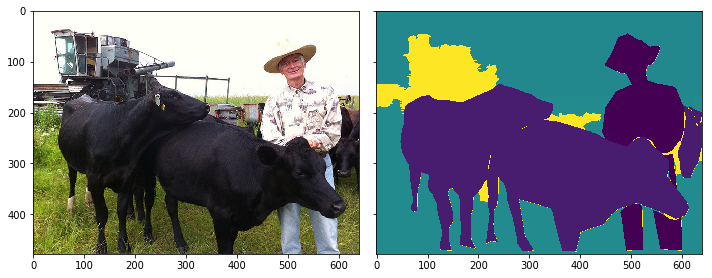

In [4]:
### visualize image and mask
from PIL import Image
from utils import plot_img_and_mask, plot_img_and_mask_transformed
import numpy as np

img = Image.open(img_loc)
mask = Image.open(mask_loc)

img_array = np.asarray(img)
mask_array = np.asarray(mask)
    
plot_img_and_mask(img_array, mask_array)

## Task 
Visualize the 10th element of the **image_id** object 

(a) the objective of performing the task i.e. what will the learner perform and gain out of that task, 
- To visulaize the stuff and thing object annotations on the image.

 
(b) a set of instructions and 
- select the 10th element of the image_id list
- using image_id, select the image_loc and mask_loc using image_mask dict.
- read image and mask using pil
- convert image and mask to numpy array
- using plot_img_and_mask, plot both img_array and mask_array
 
 
(c) the solution code. 

```python

## select the 10th element of the image_id list
image_id = list(image_mask.keys())[10]

## using image_id, select the image_loc and mask_loc using image_mask dict.
img_loc = image_mask[image_id][0]
mask_loc = image_mask[image_id][1]
print(img_loc, mask_loc)

## read image and mask using pil
img = Image.open(img_loc)
mask = Image.open(mask_loc)

## convert image and mask to numpy array
img_array = np.asarray(img)
mask_array = np.asarray(mask)
    
## using plot_img_and_mask, plot both img_array and mask_array
plot_img_and_mask(img_array, mask_array)
```

## 2.2 Applying transformations to Data.
Neural networks need standard image sizes to train. Since coco dataset contains images of different sizes and shapes (aspect ratios), we need to follow a process to process these images. Simply resizing and cropping will not work as this will change the shapes of various objects. So we will follow the following process. 
- Resize: Resize the image to some predefined standard size preserving aspect ratio of the image. 
- scale: scale the image to different sizes. Here we use (0.75, 1.0, 1.25) scales.
- pad: pad the images to crop_size.
- crop the images to a given size.
- Flip the image randomly.

Lets do this considering the following options for the above image
- resize the image with base to 544
- scale the image to one of 0.75 of resize, 1.0 of resize and 1.25 of resize. Usually scale and resize are combined. 
- pad the image to crop size (when we use 0.75 scale, the base of the image after resizing becomes 0.75x544 = 408. So we need to pad the remaining pixels with ignore_label 255 to bring it to size 512)
- crop the image to crop size


In this section we will be using the following libraries 
- [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html)
- [pillow](https://pillow.readthedocs.io/en/stable/)

most of the arguments for all the functions were self explanatory or written as comments. Incase if you have any doubts. use ?? against the functions and run in a cell. The documentation should help. For example if you don't understand what Image.open does, run **??Image.open** in a cell and the documentation will be printed.

In [7]:
## Call the required libraries
import random
import cv2
import numpy as np 
from PIL import Image

## 2.3 Resize 
Resizing preserving aspect ratio involves two steps. Given that we have image of shape (478, 640) h < w, we need to bring down the w to base_size. calculate the height preserving aspect ratio (base_size)x(h/w). Using these new dimensions, we need to resize the image. The following functions,
- **aspect_ratio_calc** will calculate the new dimensions
- **resize_image** will resize the image and label using the above calculated dimensions.

In [5]:
def aspect_ratio_calc(image, label, base_size):
    """ new dimensions based on base_size preserving the aspect ratio of the object
    """
    h, w = label.shape
    if h > w:
        h, w = (base_size, int(base_size*w/h))
    else:
        h, w = (int(base_size*h/w), base_size)
    return h, w

def resize_image(image, label, size):
    """ resize the image to give size.
    """
    h, w = size
    ## resize image using linear interpolation
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
    ## resize the mask using nearset interpolation. Note: interpolation in cv2 and resample in PIL mean the same thing.
    label = Image.fromarray(label).resize((w, h), resample=Image.NEAREST)
    label = np.asarray(label, dtype=np.int64)
    return image, label

## Quiz

If the base_size is 448 and the image height and width are 1200, 1600 respectively. what will be the new height and width of the image after aspect ratio based resizing?  

A) height = 336 and width = 448  
B) height = 597 and width = 448  
C) height = 448 and width = 336  
D) height = 448 and width = 597  

Ans) A . since height < width, width = 448 and height = int(base_size*(h/w))  

original_image_shape:(478, 640, 3)
new_height: 406 new_width: 544


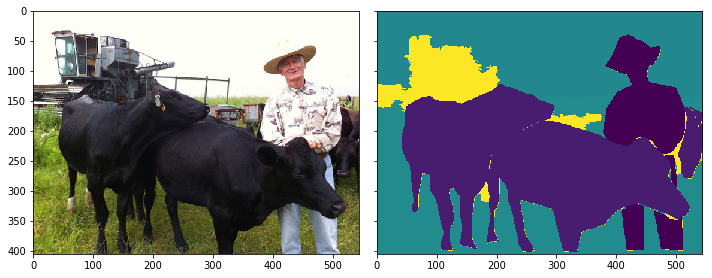

In [9]:
print("original_image_shape:{}".format(img_array.shape))
resize = 544

## calculate new height and width
new_h, new_w = aspect_ratio_calc(img_array, mask_array, resize)
print("new_height: {} new_width: {}".format(new_h, new_w))

## resize the image and mask

img_resized, mask_resized = resize_image(img_array, mask_array, (new_h, new_w))

## Plot the resized image and mask
plot_img_and_mask(img_resized, mask_resized)

## 2.4 Scale the image.
During resizing the image height and width after resizing is changed from (478, 670) to (406, 544). Now we can scale this image to different levels. If we use a scale param as 0.75. the new image height and width becomes 304 and 408 respectively (406 x 0.75, 544 x 0.75). If we use a scale param of 1.25, The new image and height becomes 507 and 680.  
Usually scale is integrated between **aspect_ratio_cal** and **resize_image** functions. First we calculate the **aspect_ratio** based new img dims, we further calculate the new dims using the scale params. We will be using scale of 1.25 in this section to exectcute this..

original_image_shape:(478, 640, 3)
Before scaling: new_height: 406 new_width: 544
After scaling: new_height: 507 new_width: 680


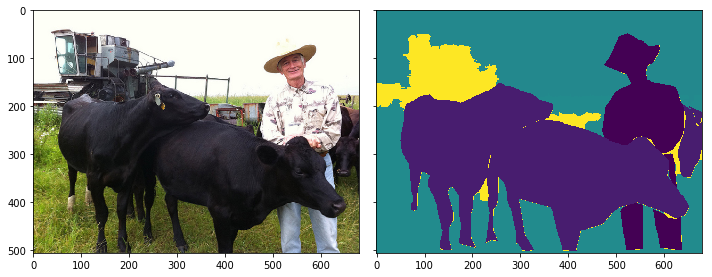

In [30]:
print("original_image_shape:{}".format(img_array.shape))
resize = 544
scale = 1.25

## calculate new height and width
new_h, new_w = aspect_ratio_calc(img_array, mask_array, resize)
print("Before scaling: new_height: {} new_width: {}".format(new_h, new_w))

## Scaling image and height
scale_h, scale_w = int(new_h * scale), int(new_w * scale)
print("After scaling: new_height: {} new_width: {}".format(scale_h, scale_w))

## resize the image and mask
img_resized, mask_resized = resize_image(img_array, mask_array, (scale_h, scale_w))

## Plot the resized image and mask
plot_img_and_mask(img_resized, mask_resized)

### 2.5 pad the image.
Since we need the final crop size of 512 and the height of the image is only 507. We need to pad the image height to 512. We are using mean_rgb of the coco_dataset to add as pixel values (this is same as we fill na values in tabular data. We can also pad with any other number as we will not use these pixels for calculating the loss) and mapping them to ignore label (255, we can also use any value which is less 255 and not included in our labels (0-182), while calculating loss, we will choose this label to ignore these pixels. Also note that we cannot use any number >255, as these matrices are mostly np.uint8 data types and any number between greater than 255 is clipped to nearset int, 256 is clipped to 256-255=1, which will make it 1 class **(careful)** ) on output. As ignore_label is ignored while training neural network, this will not have any effect on the network.

Also note that, padding is only used when the image height and width is smaller the crop_size. Incase in the above section, if we have used scale paramter of 1.5, the scaled and resized image_height would have been 609.0 and width would have been 816. Since both height and width are above crop size we don't need any padding. We randomly select two points each in both x direction and y direction with length of crop_size (512) and crop the image (next section)

In [28]:
def pad_image(image, label, required_size, mean_bgr, ignore_label):
    """ pad the image to a give size.
    """
    h, w = label.shape
    pad_h = max(required_size - h, 0)
    pad_w = max(required_size - w, 0)
    pad_kwargs = {
        "top": 0,
        "bottom": pad_h,
        "left": 0,
        "right": pad_w,
        "borderType": cv2.BORDER_CONSTANT,
    }
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(image, value=mean_bgr, **pad_kwargs)
        label = cv2.copyMakeBorder(label, value=ignore_label, **pad_kwargs)
    return image, label

new image height and width :(512, 680)


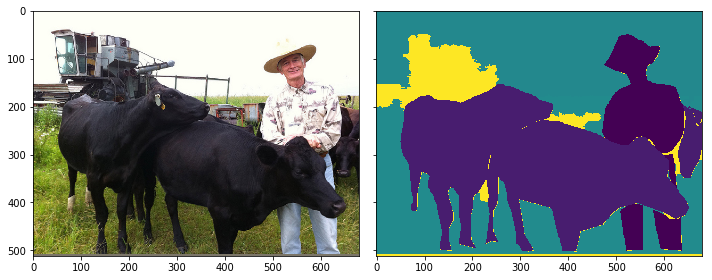

In [31]:
crop_size = 512

## mean values to fill the padded image
mean_rgb = (122.675, 116.669, 104.008)

## mean values to fill the target values 
ignore_label= 255

## pad the image
image_padded, mask_padded = pad_image(img_resized, mask_resized, crop_size, mean_rgb, ignore_label)
print("new image height and width :{}".format(image_padded.shape[:2]))

## Plot the image and mask
plot_img_and_mask(image_padded, mask_padded)

## 2.6 Crop the image. 
As the image height is 512 (equal to crop size) and width is 680 (greater than crop size) . We need to select any two points on the x_axis such that the distance between the two points is equal to crop_size (512).

The **crop_image** function return below crops the images and labels in both the x and y axis to required dimensions. 

In [32]:
def crop_image(image, label, required_size):
    """cropping the image.
    """
    h, w = label.shape
    start_h = random.randint(0, h - required_size)
    start_w = random.randint(0, w - required_size)
    end_h = start_h + required_size
    end_w = start_w + required_size
    image = image[start_h:end_h, start_w:end_w]
    label = label[start_h:end_h, start_w:end_w]
    return image, label


cropped final image size: (512, 512)


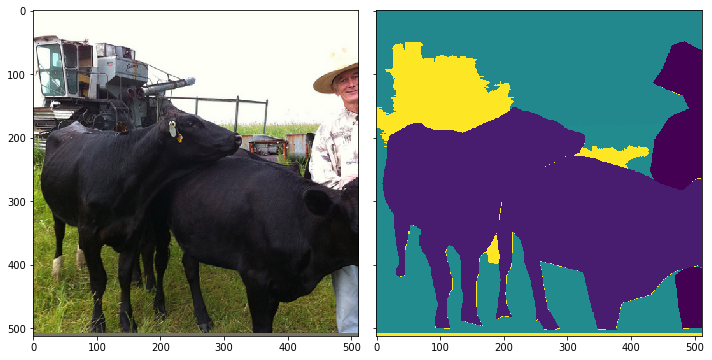

In [33]:
img_cropped, mask_cropped = crop_image(image_padded, mask_padded, crop_size)
print("cropped final image size: {}".format(img_cropped.shape[:2]))
plot_img_and_mask(img_cropped, mask_cropped)

## 2.7 Flip
Randomly flipping the image from left to right will allow the network to see one image 2 perspectives. Suppose we use random flipping probability to be 0.5, It means that the image is flipped once every time it is called twice.

In [34]:
def flip_image(image, label, u=0.5):
    """Flip the image randomly
    """
    if random.random() < u:
        image = np.fliplr(image).copy()
        label = np.fliplr(label).copy()
    return image, label

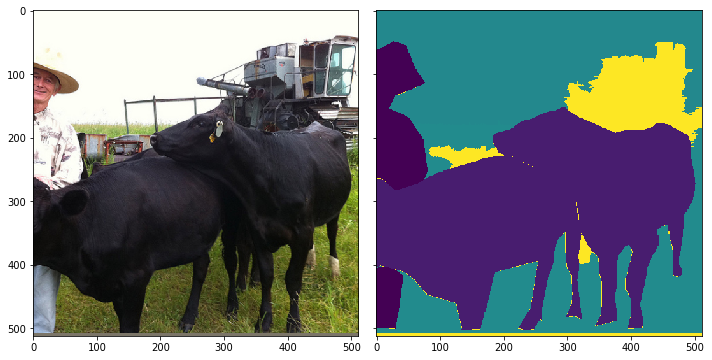

In [35]:
image_flipped, mask_flipped = flip_image(img_cropped, mask_cropped, u=1)
plot_img_and_mask(image_flipped, mask_flipped)

So, the input image and mask which we have previously are now resized, scaled, padded, cropped and flipped. Since scale, crop and flip has randomness involved. The same image when called multiple times, gives multiple outputs.

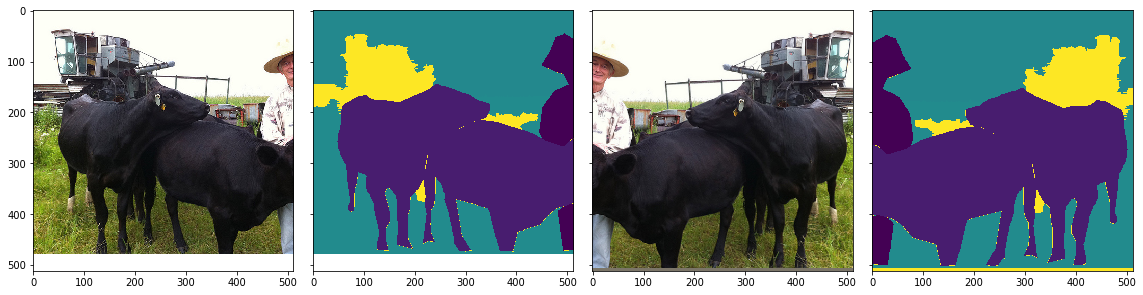

In [36]:
# To visualize the input data and output transformed data.
plot_img_and_mask_transformed(img_array, 
                              np.expand_dims(mask_array,2), 
                              image_flipped, 
                              np.expand_dims(mask_flipped,2 ))

## 2.8 Combining all the transformation
Combining all the transformations and creating one function will allow us to use it in our keras_dataloader later. The **agumentation** function below takes, image, mask and  some transformation parameters as input and outputs transformed image and mask.

The transformed parameters include **resize**, **flip**, **crop_size**, **scales**, **mean_bgr** and **ignore_label**, which we have discussed in-depth before.

In [37]:
def augmentation(image, label, resize,flip,  crop_size, \
                 scales, \
                 mean_bgr,\
                ignore_label=255):
    """ Combining all the augmentations
    """
    h, w = aspect_ratio_calc(image, label, resize)
    
    scale_factor = random.choice(scales)
    h, w = (int(h * scale_factor), int(w * scale_factor))
    image, label = resize_image(image, label, (h, w))
    
    # Padding to fit for crop_size
    image, label = pad_image(image, label, crop_size, mean_bgr, ignore_label)
    
    ## randomly Crop the image to required_size
    image, label = crop_image(image, label, crop_size)
    
    if flip:
        image, label = flip_image(image, label, 0.5)
    return image, label

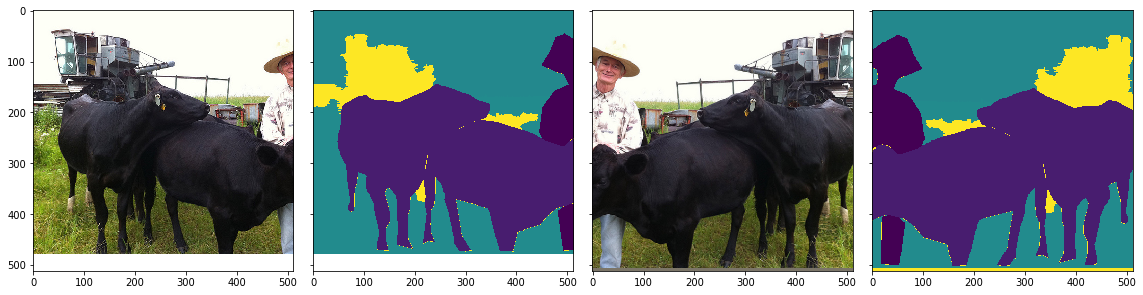

In [38]:
## Defining everything in one function. Everytime u call this function, the output will be different.
img_aug, mask_aug = augmentation(img_array.copy(), mask_array.copy(), resize=544, flip=True, crop_size=512, 
                        scales = (0.75, 1.0, 1.25), 
                        mean_bgr=(122.675, 116.669, 104.008),
                        ignore_label=255)

plot_img_and_mask_transformed(img_array, np.expand_dims(mask_array, 2),
                              img_aug, np.expand_dims(mask_aug, 2))

## Task 

visualize the input image and transformed image along with its masks of the 10th element in the image_id list. Use the following params 
- resize = 544
- flip = False
- crop_size = 512
- scales = (0.5, 1.0, 1.5)
- mean_bgr = (122.675, 116.669, 104.008)
- ignore_label = 255

(a) the objective of performing the task i.e. what will the learner perform and gain out of that task,   
To visually see how the transformations work

(b) a set of instructions and 
- select the 10th element of the image_id list
- using image_id, select the image_loc and mask_loc using image_mask dict.
- read image and mask using pil
- convert image and mask to numpy array
- use agumentation function to generate img_aug and mask_aug of the input images using the params used above 
- using plot_img_and_mask_transformed to plot img_array, mask_array, img_aug and mask_aug
 
 
(c) the solution code. 

```python

## select the 10th element of the image_id list
image_id = list(image_mask.keys())[10]

## using image_id, select the image_loc and mask_loc using image_mask dict.
img_loc = image_mask[image_id][0]
mask_loc = image_mask[image_id][1]
print(img_loc, mask_loc)

## read image and mask using pil
img = Image.open(img_loc)
mask = Image.open(mask_loc)

## convert image and mask to numpy array
img_array = np.asarray(img)
mask_array = np.asarray(mask)

## use agumentation function to generate img_aug and mask_aug of the input images using the params used above 
img_aug, mask_aug = augmentation(img_array.copy(), mask_array.copy(), resize=544, flip=False, crop_size=512, 
                        scales = (0.5, 1.0, 1.5), 
                        mean_bgr=(122.675, 116.669, 104.008),
                        ignore_label=255)

plot_img_and_mask_transformed(img_array, np.expand_dims(mask_array, 2),
                              img_aug, np.expand_dims(mask_aug, 2))
```

# Topic-3 Color Transformations
Now we will look at some transforms which doesn't require the same transformations to be applied on mask as the locations of the object doesn't change in the image. We have the following transformations 

-  Random channel shift 
- Converting the color image to grayscale 
- Contrast Adjustments 
- Brightness Adjustments 
- Saturation Adjustments 

# 3.1 Random Channel Shift
Channel shifting is the process of taking the red, green or blue values of pixels in an image and adding/subtracting some random value to each channel separtely. This will not change the variation inside each channel but would shift the mean of each channel. As we can see in the below image, some colors became bright but overall there is no change in location of objects.

In [39]:
def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return np.uint8(x)

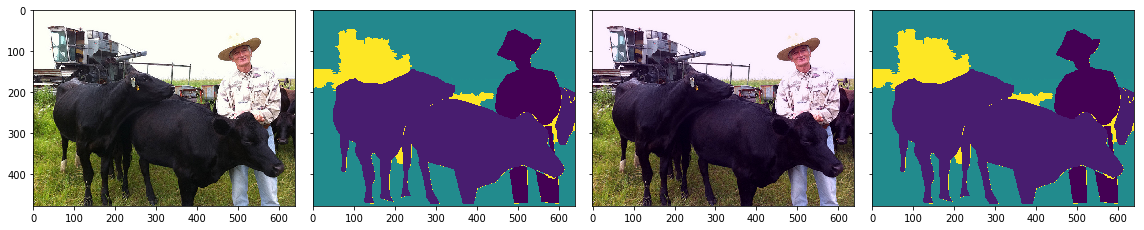

In [40]:
img_chsh = random_channel_shift(img_array, limit=35)
plot_img_and_mask_transformed(img_array, \
                              np.expand_dims(mask_array, 2), \
                              img_chsh, \
                              np.expand_dims(mask_array, 2))

# 3.2 Grayscale 
converting RGB image into Grayscale 

In [41]:
def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return np.uint8(img)

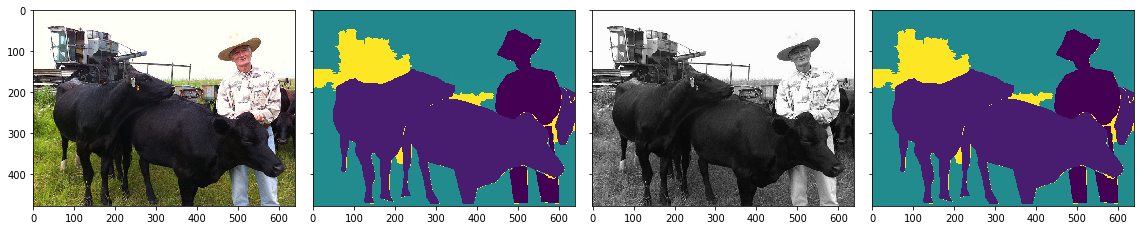

In [42]:
img_gray = random_gray(img_array, u=1)
plot_img_and_mask_transformed(img_array,\
                              np.expand_dims(mask_array, 2),\
                              img_gray,\
                              np.expand_dims(mask_array, 2))

# 3.3 Brightness and Contrast 
**Brightness** refers to the overall lightness or darkness of the image. Increasing the brightness every pixel in the frame gets lighter. **Contrast** is the difference in brightness between objects in the image. Increasing the contrast makes light areas lighter and dark area in the frame becomes much darker.

In [43]:
def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 255.)
    return np.uint8(img)

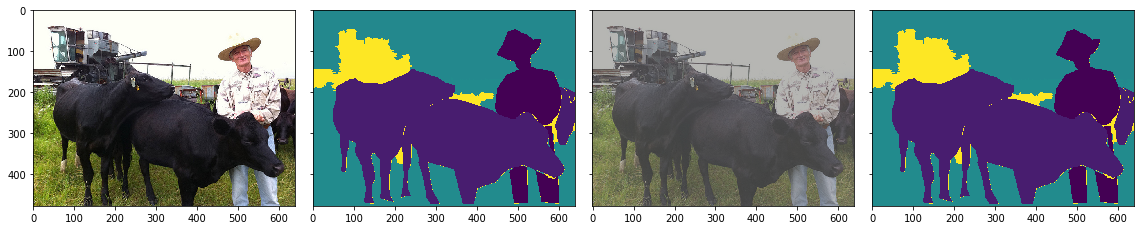

In [44]:
img_contrast = random_contrast(img_array, limit=(-1, 1.),  u=1)
plot_img_and_mask_transformed(img_array,\
                              np.expand_dims(mask_array, 2), \
                              img_contrast, \
                              np.expand_dims(mask_array, 2))

In [45]:
def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 255.)
    return np.uint8(img)

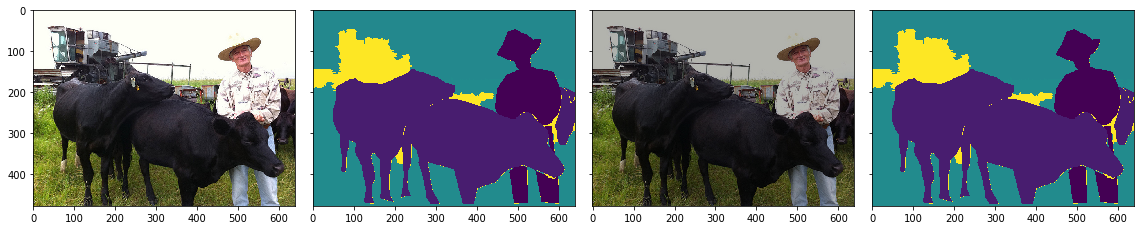

In [46]:
img_brightness = random_brightness(img_array, limit=(-0.3, 0.3),  u=1)
plot_img_and_mask_transformed(img_array,\
                              np.expand_dims(mask_array, 2), \
                              img_brightness, \
                              np.expand_dims(mask_array, 2))

# 3.4 Saturation
Saturation is basically the intensity of a color, saturation determines the strength of a particular color. low saturation has the true color while saturation adds white color to the pure one. so highly saturated image will be too bright i.e. white

In [49]:
def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 255.)
    return np.uint8(img)

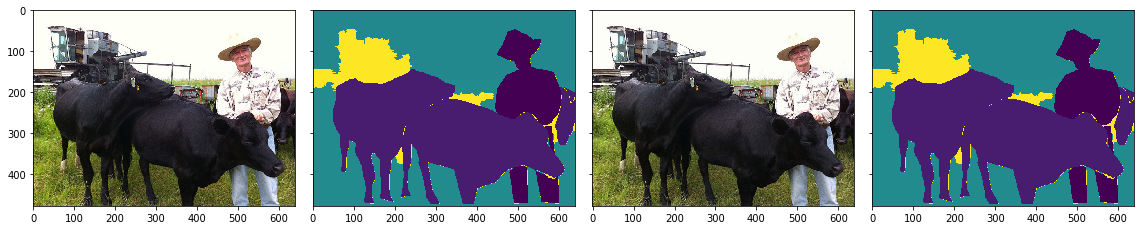

In [50]:
img_sat = random_saturation(img_array, limit=(-0.9, 0.9),  u=1)
plot_img_and_mask_transformed(img_array,\
                              np.expand_dims(mask_array, 2), \
                              img_sat, \
                              np.expand_dims(mask_array, 2))

## Task 
Perform **random_contrast** on input_image and plot input_image, input_mask, output image and its mask using **plot_img_and_mask_transformed**. use 
- limit = (-1.0, 1.0)
- u =1 (perform contrast adjustment)

(a) the objective of performing the task i.e. what will the learner perform and gain out of that task,   
To visually see how the color transformations are applied only on image and not on mask.

(b) a set of instructions and 
- select the 10th element of the image_id list
- using image_id, select the image_loc and mask_loc using image_mask dict.
- read image and mask using pil
- convert image and mask to numpy array
- use random_contrast function to generate img_aug of input image using the params described above 
- using plot_img_and_mask_transformed to plot img_array, mask_array and transformed image and mask.
 
 
(c) the solution code. 

```python

## select the 10th element of the image_id list
image_id = list(image_mask.keys())[10]

## using image_id, select the image_loc and mask_loc using image_mask dict.
img_loc = image_mask[image_id][0]
mask_loc = image_mask[image_id][1]
print(img_loc, mask_loc)

## read image and mask using pil
img = Image.open(img_loc)
mask = Image.open(mask_loc)

## convert image and mask to numpy array
img_array = np.asarray(img)
mask_array = np.asarray(mask)

## use agumentation function to generate img_aug and mask_aug of the input images using the params used above

img_contrast = random_contrast(img_array, limit=(-1, 1.),  u=1)
plot_img_and_mask_transformed(img_array,\
                              np.expand_dims(mask_array, 2), \
                              img_contrast, \
                              np.expand_dims(mask_array, 2))
```

## Topic-4 Unifying all the transformations

- Lets combine all color transformations and create a function called **random_color_transformations**. This will help us in performing each color transform separately on top of each other and give a different perspective of input image everytime we call the image.
- **random_color_transformations** when called with **agumentation** will further amplify the data transformation methods and help us in augmenting the dataset and standardize the sizes of all the images to one unified size.

In [47]:
def random_color_augmentation(img, mask):
    img = random_channel_shift(img, limit=10)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    return img, mask

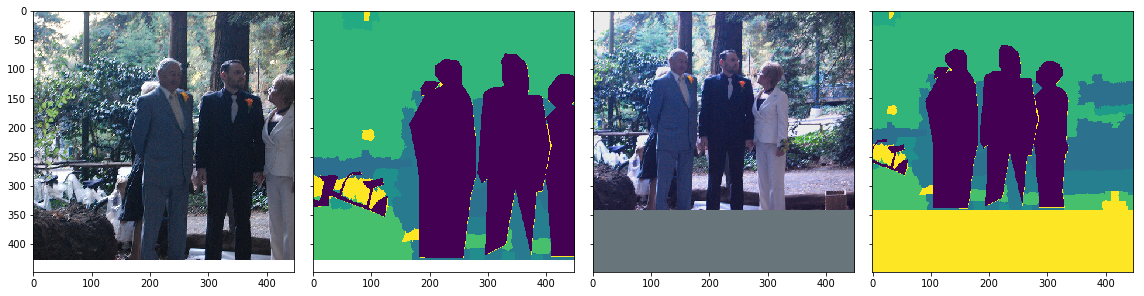

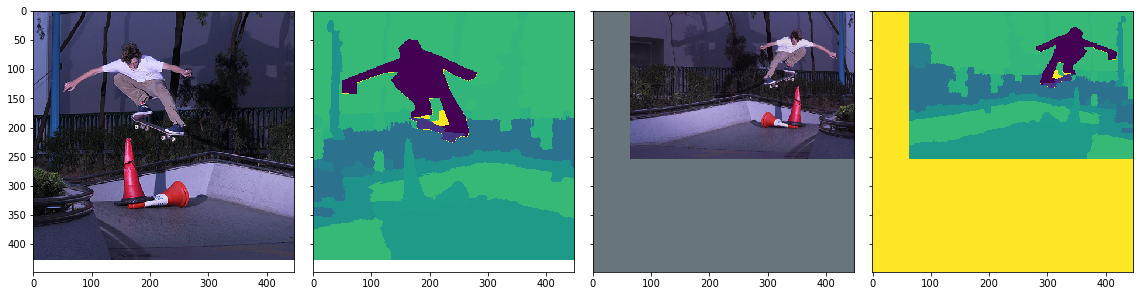

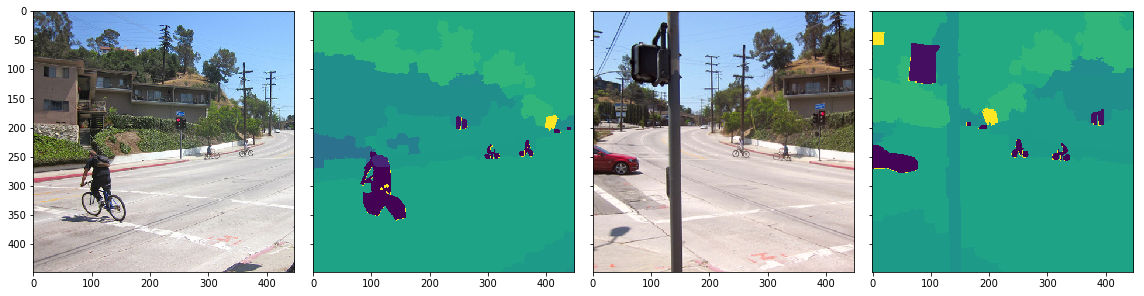

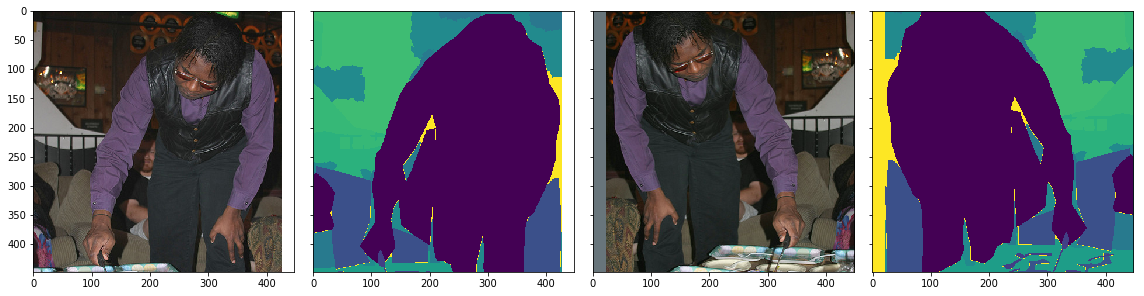

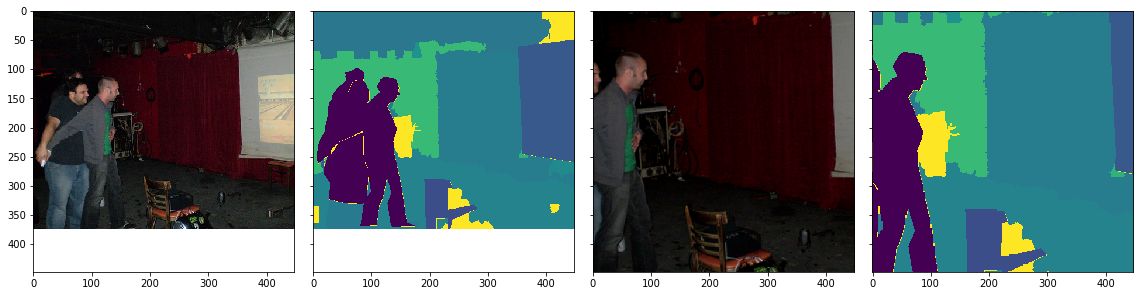

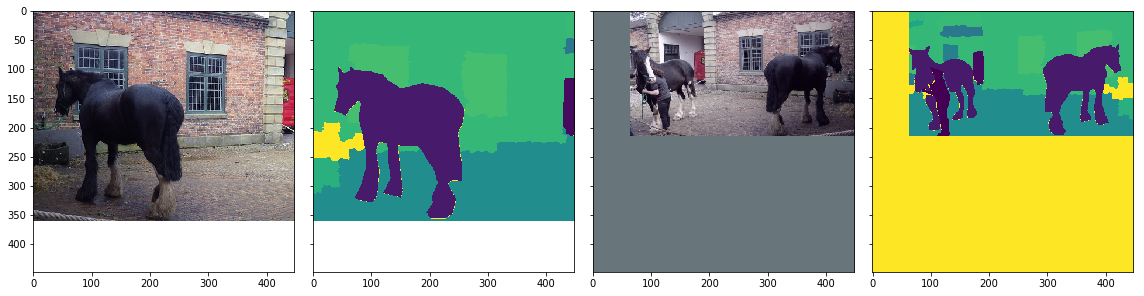

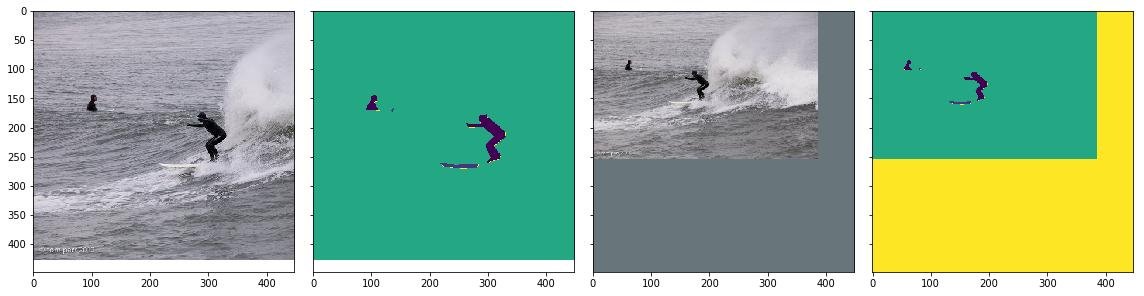

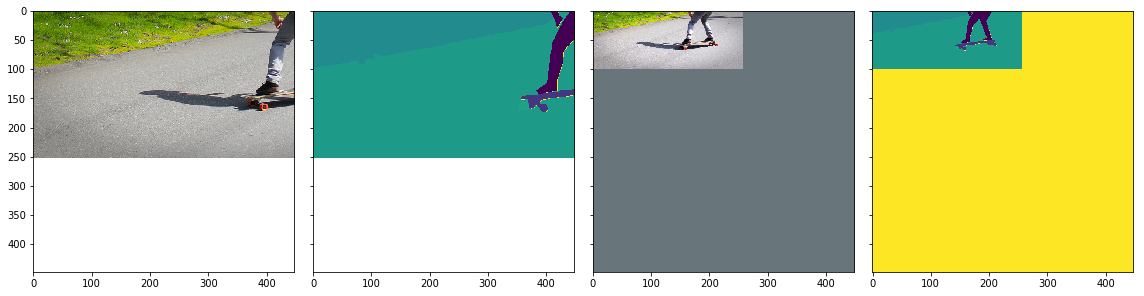

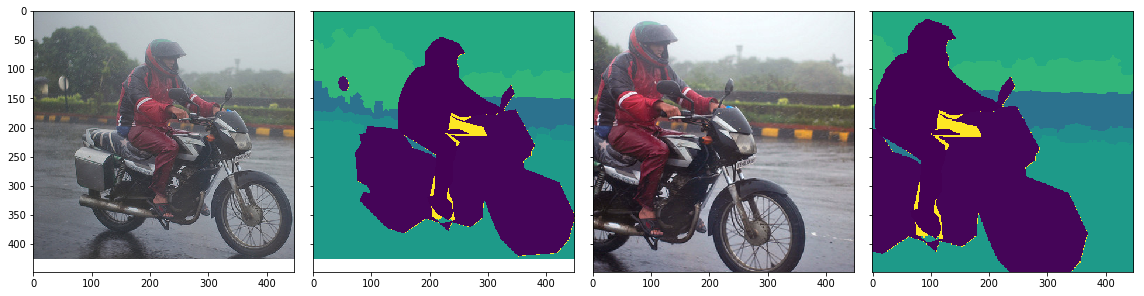

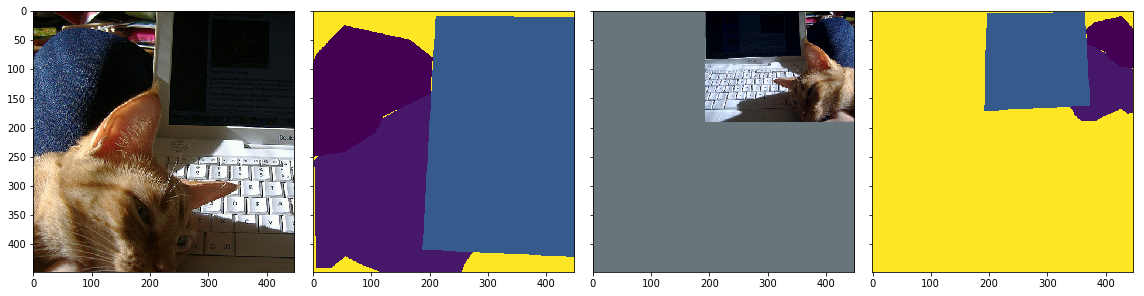

In [51]:
## Collect a few image_ids randomly and print them to visualize the transformed outputs
img_ids = [list(image_mask.keys())[np.random.randint(len(image_mask))] for i in range(10)]
for i in img_ids:
    img_loc = image_mask[i][0]
    mask_loc = image_mask[i][1]
    img = np.asarray(Image.open(img_loc))
    mask = np.asarray(Image.open(mask_loc))
    img_aug, mask_aug = random_color_augmentation(img, mask)
    img_aug, mask_aug = augmentation(img_aug, mask_aug, resize=512, flip=True, crop_size=448, 
                        scales = (0.5, 0.75, 1.0, 1.25, 1.5), 
                        mean_bgr=(104.008, 116.669, 122.675),
                        ignore_label=255)
    mask = np.expand_dims(mask, 2)
    mask_aug = np.expand_dims(mask_aug, 2)
    plot_img_and_mask_transformed(img, mask, img_aug, mask_aug)

## Topic-5 Buidling keras data loader for image_segmentation

## Data Generator 
In this section since we understood how data augmentation works and whats inside the hood. Now our task is to build a data genertor which will feed data to our network continously.  The data generator should randomly pick N Ids (batch size), pick images and corresponding masks based on ids, pass it through our augmentation module and output the final images and masks. The two most important tasks with us are 
- build a data_generator for data
- plot one batch of images to make sure that whatever is going into the network is correct

## 5.1 Build a data_generator for data
keras package has **keras.utils.Sequence** module which will allow you to write your own custom data generators. Our Default ImageDataGenerator, which we used in classification also uses **keras.utils.Sequence**[link](https://github.com/keras-team/keras/blob/9d33a024e3893ec2a4a15601261f44725c6715d1/keras/preprocessing/image.py#L64) . So lets have a close look at what keras.utils.Sequence contains.
- It is a class function which have getitem func, this outputs image and its respective mask for a given index (ID of the image). index values ranges from 0 to length of the dataset.
- len function, where we need to define how many batch of images are there in the dataset, So the datagenerator will know how many batches to run through for one epoch.
- on_epoch_end. This is an optinal method, which can be used to tell what to do after an epoch completes. We can use it to shuffle the data at the end of an epoch.
- iter func, this is again an optional method and can be ignored.

Lets define the class function. we have the following things
- root: str root location of the images 
- ids: list. List of all the image ids
- batch_size: 32 number of images to read in one batch
- resize_size: int, To resize the image to give size 
- crop_size: int, final size to output of the data loader 
- flip: True/False, weather to flip the image or not.
- scales: tuple, vales to randomly scale the image to one of the scales in the mentioned tuple
- normalize: True/False, weather to perform image normalization or not.
- ignore_label:int, the label that needs to be ignored.
- mean_bgr: tuple, the channel wise mean of the dataset in BGR format.
- color_transforms: True/Flase: weather to perform the color_transformation or not. If yes, we need to call the transformation function we called before.
- shuffle : True/False, weather to shuffle images after each and every epoch or not 


### 5.2 process flow inside the datagenerator
Once the **CocostuffDataGenertor** is build. We can retrieve batch of images using ```__getitem__``` method as following 
```python
train_gen = CococstuffDataGeneretor()
num = 0
input_images, label_targets = train_gen[num]
```
the ```num``` parameter can be anything between 0 to number of batches(num_images/batch_size).

The ```__getitem_``` function first randomly selects batch_size set of image_ids and calls the ```get_image_and_mask``` function to retrieve images and labels of the ids. The structure of the datasets we created is in the following way
```
train_input_dataset: ../../data/cocostuff/images/train/*.jpg
train_target_dataset: ../../data/cocostuff/images/stuff_train/*.png
val_input_dataset: ../../data/cocostuff/images/val/*.jpg
val_target_dataset: ../../data/cocostuff/images/stuff_val/*.png
```
Here the root is `../../data/cocostuff`, folder_name is train, stuff_train, val, stuff_val for train_input_images, train_target_images, val_input_dataset and val_target_datasets respectively. The function is explained below. it takes root, folder_name and id as input and outputs image and label.
```python
def get_image_and_mask(root, folder_name, img_id):
    ## Image location
    image_path = join(root, "images/", folder_name, img_id + ".jpg")
    
    ## Label location
    label_path = join(root, "images/", "stuff_"+ folder_name, img_id + ".png")
    
    # Load an image and label
    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    ## Return the image and label 
    return image, label
```

Once after selecting a batch of image_ids. Each set of image and label is read using the above ``get_image_and_mask`` function, necessary transformation as disucssed above are performed and finally outputs two 4D numpy array [N, H, W , C] as output, (where N is number of images, H, W is the height and width of the image and C is the number of channels) One for input images and the other for output mask. The following is the code for the same. In the keras module below, we can see the function ```data_generation``` which contains the same code discussed here. 

```python

imgs = []
masks = []

## Each img_id
for i in list_ids_temp:

    ## Read image and mask 
    img, mask = get_image_and_mask(i)
    
    ## weather to perform color transforms or not.
    if color_transforms:
        img, mask = random_color_augmentation(img, mask)
    
    ## Explaining how the augmentation works
    img_aug, mask_aug = augmentation(img, mask, \
                                     resize, \
                                     flip \
                                     crop_size\
                                     scales\
                                     mean_bgr,\
                                     ignore_label )
    ## Converting image to float type
    img_aug = np.float64(img_aug)
    
    ## normalize the image with channel wise mean
    if normalize:
        img_aug -= np.float64(smean_bgr)
    
    # Converting the ignore label from 255 to -1 so that labels start from -1 and end at 182.
    mask_aug[mask_aug==255.] = -1
    
    ## Appending to the lists
    imgs.append(np.expand_dims(img_aug, 0))
    masks.append(np.expand_dims(mask_aug, 0))
    
## Concatenating to form a 4D tensors.
imgs, masks = np.concatenate(imgs), np.concatenate(masks)
```

with remaining things almost being the same, the ```__get_item``` and ```data_generation``` can be changed according to the datasets and problem statements requirements, which we will do in the next chapter.  

In [4]:
import keras
from coco_dataloader import augmentation, random_color_augmentation
import numpy as np 
from os.path import join
import cv2


class CocoStuffDataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, \
                 root="../input", \
                 folder_name = "train2017",\
                 batch_size=2, \
                 resize=512, \
                 flip = True, \
                 crop = 448,\
                 scales = (1., 1.25),\
                 mean_bgr = (0, 0, 0),\
                 normalize = False, \
                 ignore_label = 255., \
                 color_transforms=False, \
                 shuffle=False):
        self.list_ids = list_ids
        self.root = root
        self.folder_name = folder_name
        self.batch_size = batch_size
        self.resize = resize 
        self.flip = flip
        self.crop = crop
        self.scales = scales 
        self.mean_bgr = mean_bgr
        self.normalize = normalize
        self.ignore_label = ignore_label
        self.color_transforms = color_transforms
        self.shuffle = shuffle 
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index* self.batch_size: (index+1)* self.batch_size]
        list_of_ids = [self.list_ids[i] for i in indexes]
        X, y = self.data_generation(list_of_ids)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def data_generation(self, list_ids_temp):
        imgs = []
        masks = []
        for i in list_ids_temp:
            img, mask = self.get_image_and_mask(i)
            if self.color_transforms:
                img, mask = random_color_augmentation(img, mask)
            img_aug, mask_aug = augmentation(img, mask, \
                                             resize=self.resize, \
                                             flip=self.flip, \
                                             crop_size=self.crop,\
                                             scales = self.scales,\
                                             mean_bgr = self.mean_bgr,\
                                             ignore_label = self.ignore_label)
            img_aug = np.float64(img_aug)
            if self.normalize:
                img_aug -= np.float64(self.mean_bgr)
            mask_aug[mask_aug==255.] = -1
            imgs.append(np.expand_dims(img_aug, 0))
            masks.append(np.expand_dims(mask_aug, 0))
        return np.concatenate(imgs), np.concatenate(masks)
        
    def get_image_and_mask(self, img_id):
        image_path = join(self.root, "images/", self.folder_name, img_id + ".jpg")
        label_path = join(self.root, "images/", "stuff_"+self.folder_name, img_id + ".png")
        # Load an image and label
        image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        return image, label

Using TensorFlow backend.


In [54]:
## List all the images
import glob
ids = glob.glob("../../data/cocostuff/images/train/*")
img_ids = [i.rsplit("/")[-1].rsplit(".")[0] for i in ids]
len(img_ids)

5500

In [57]:
train_datagen =  CocoStuffDataGenerator(img_ids, \
                                      root="../../data/cocostuff/", \
                                      folder_name = "train",\
                                      batch_size=16, \
                                      resize=544, \
                                      flip = True, \
                                      crop = 512,\
                                      scales = (0.9, 1., 1.1, 1.2,  1.25),\
                                      mean_bgr = (104.008, 116.669, 122.675),\
                                      normalize = False, \
                                      ignore_label = 255., \
                                      color_transforms=True, \
                                      shuffle=True)

In [58]:
X, y = train_datagen[10]

## 5.2 visualizing a batch of images from dataloader.
It is very important to check what is going into your dataloader. We are doing a lot of stuff inside our datagenetor, We first read the images, do color transforms, agument the data with resize, scale, pad, crop and flip methods, subtract each channel with its mean. The chance of any function going wrong and giving wrong outputs is high. So it is important to check what the data loader outputs look like.

Lets visualize these images and see how if everything is going well or not. To visualize images in a grid, we are using montage function from skimage.util. **montage** takes a 3D numpy array [N, H, W]. It places each image inside a single image as shown below

In [60]:
from skimage.util import montage # to visualize all the images at once.
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, '$\\Delta$T Mask')

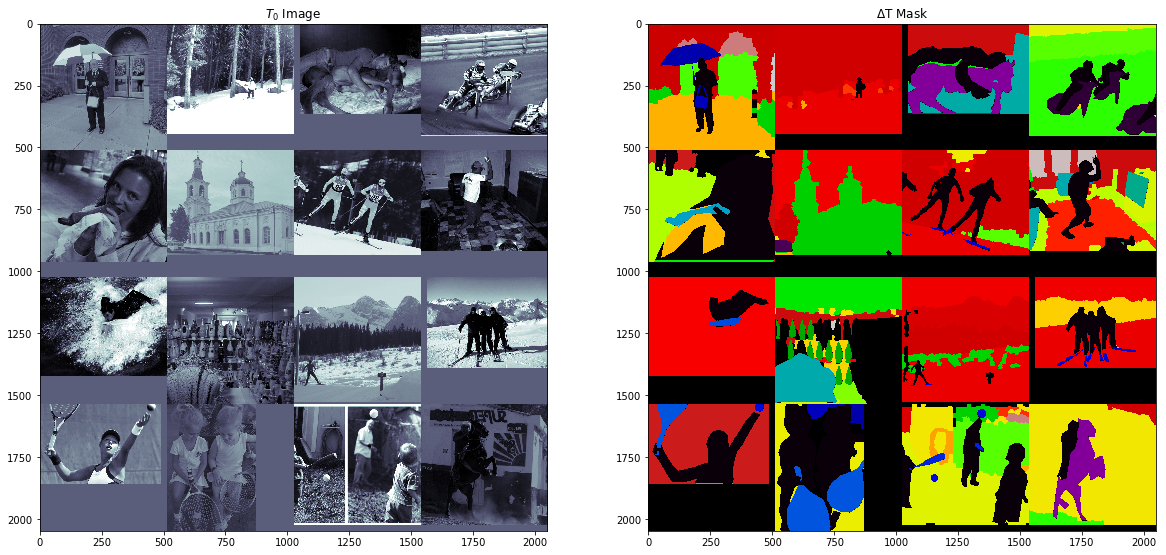

In [61]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('Image')
ax3.imshow(montage(y[:, :, :]), cmap = 'nipy_spectral')
ax3.set_title('Mask')

This looks perfect and proves that our data loader is working fine. points to be noted here.
Note: Since transforms is true, if you call the **train_datagen** func once again with the same index. We will get the same images in different ways (random_transformations)

## Task
- Initialize CocoStuffDataGenerator with batch_size 8.
- Find the length of initalized data genertor - (Number of batches)
- select randomly a batch of images 
- visualize images and their respective masks using **skimage.util.montage**

 (a) the objective of performing the task i.e. what will the learner perform and gain out of that task, 
 To understand and use **CocoStuffDataGenerator**
 
 (b) a set of instructions and 
 - Call CocoStuffDatagenetor with the same params as used above with change in batch_size
 - Find the length of the data genertor using __len__ attribute , select randomly a batch of images
 - visualize the images and respective masks using **skimage.util.montage**
 
 
 (c) the solution code. 

```python 
## 1
train_datagen =  CocoStuffDataGenerator(img_ids, \
                                      root="../../data/cocostuff/", \
                                      folder_name = "train",\
                                      batch_size=8, \
                                      resize=544, \
                                      flip = True, \
                                      crop = 512,\
                                      scales = (0.9, 1., 1.1, 1.2,  1.25),\
                                      mean_bgr = (104.008, 116.669, 122.675),\
                                      normalize = False, \
                                      ignore_label = 255., \
                                      color_transforms=True, \
                                      shuffle=True)

##  length of the datagenerator 
length_datagen = len(train_datagen)

## select randomly a batch of images 
random_int = np.random.randint(length_datagen)
X, y = train_datagen[random_int]


## Visualize the image
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('Image')
ax3.imshow(montage(y[:, :, :]), cmap = 'nipy_spectral')
ax3.set_title('Mask')
```

## THE END